In [112]:
import pywikibot
import queue
import gensim
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # Suppresses gensim errors

### Things I've installed:
1. wikipedia (query wikipedia) - not used
2. pywikibot (more advanced queries)
3. wikiutils (read sql.gz files) - not yet used. possibly in the future
4. gensim (for NLP and specifically using Google's word2vec)

### Load word2vec embeddings

In [113]:
# Obviously override this to your local location
#model_addr = '/Users/benjaminrafetto/Code/cs182/project/data/GoogleNews-vectors-negative300.bin'

# claire's address 
model_addr = '/Users/clairestolz/CS182/CS182-Final-Project/data/GoogleNews-vectors-negative300.bin'

In [114]:
model = gensim.models.KeyedVectors.load_word2vec_format(model_addr, binary=True)  

### Crude definition of distance

In [115]:
# Currently uses average word distances from word2vec embeddings
def get_distance_new(topic, model, goal):
    assert type(topic) is list and type(goal) is list
    try:
        distances = [model.distance(x, y) for x in topic for y in goal]
        return (np.average(distances) + np.min(distances) / 2.0)  # Combination of average and minimum
    except:
        return np.Infinity


### Connect to Wikipedia

In [116]:
site = pywikibot.Site("en", "wikipedia")

In [117]:
def greedy_word2vec_path(start, goal, maxIters=30, verbose=False):
    start_list = process_word(start)
    goal_list = process_word(goal)
    assert get_distance_new(start_list, model, goal_list) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    fringe.put((np.Inf, start_page))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with distance {}".format(page.title(), priority))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if p.title() not in visited:
                visited.append(p.title())
                processed = process_word(p.title())
#                 print(p.title(), processed)
                distance = get_distance_new(processed, model, goal_list)
                fringe.put((distance, p))

    return []
#     raise Exception("Unable to find goal node.")

In [ ]:
def process_word(topic, model=model):
    if not topic:  #No topic. Stop.
        return []
    
    if topic in model:
        return [topic]

    output = []
    words = topic.split(' ')

    #Iteratively search word2vec for shorter and shorter phrases
    for j in range(len(words), 1, -1):
        test = '_'.join(words[:j])
        if test in model:
            return [test] + process_word(' '.join(words[j:]))

    if words[0] in model:
        output.append(words[0])
    return output + process_word(' '.join(words[1:]))

### Test algorithm

In [ ]:
examples = [("speech", "lacrosse"),
            ("mantra", "dna"),
            ("Parthenon", "Natural Environment"),
            ("Feces", "Poet"),
#             ("penguin", "sans-serif"),  #sans-serif is not in the dictionary
            ("angelina jolie", "nitrogen"),
            ("Carrie Fisher", "Death of Adolf Hitler"),
            ("Lacrosse", "Comedian"),
            ("Dictionary", "Atmosphere of Earth"),
            ("Broadway theatre", "Wall Street"),
            ("Life expectancy", "Graphical User Interface"),
            ("Diazepam", "Death"),
            ("Moors", "Aryan"),
            ("Michelangelo", "Horror Fiction"),
            ("Jim Henson", "Gin"),
            ("Continental Army", "Computer Multitasking"),
            ("World Health Organization", "Ecosystem"),
            ("Blood pressure", "Mathematics"),
            ("War of 1812", "Queens of the Stone Age"),
            ("Onomatopoeia", "Wiki"),
            ("Church of England", "Joan Baez"),
            ("Nuclear Power", "Canadians"),
            ("Multi-sport event", "Ku Klux Klan"),
            ("Pony Express", "Augustus"),
            ("Organization", "Parthenon"),
            ("Battleship", "Dream"),
            ("The Cosby Show", "Marine biology"),
            ("DNA replication", "Muscle car"),
            ("Mammal", "Montreal"),
            ("River", "Engine"),
            ("Louis Armstrong", "Nuclear Power"),
            ("Entertainment", "Ralph Waldo Emerson"),
            ("Bilirubin", "Architecture"),
            ("Association football", "Axis powers"),
            ("World Series", "Nuclear warfare"),
            ("Sherlock Holmes","Magnetic resonance imaging"),
            ("Waterboarding","World War II"),
            ("World Trade Organization", "Ant"),
            ("Printed circuit board", "Typhoid fever"),
            ("Statistics","Renaissance"),
            ("Radio","Personal computer"),
            ("Bette Midler","Jellyfish"),
            ("Sigmund Freud","Vacuum"),
            ("Credit card","String theory"),
            ("Radiohead","Magnetic field"),
            ("Biosphere","Nobel Prize in Physiology or Medicine"),
            ("Mick Jagger","Knife"),
            ("West Indies","Gastroesophageal reflux disease"),
            ("Wesley Snipes","Computer science"),
            ("Airline","Bavaria"),
            ("Nevada","Maltose")
           ]

In [21]:
start, goal = examples[np.random.choice(len(examples))]
print("Searching for shortest path from {} to {}".format(start,goal))

Searching for shortest path from World Series to Nuclear warfare


### To-Do: exclude Wikipedia: Category: Talk:

### Generate data for greedy search:

In [19]:
for start, goal in examples[-1:]:
    path = greedy_word2vec_path(start, goal, maxIters=50, verbose=False)
    print("Length", len(path), "Path", path)

Length 4 Path ['Statistics', 'Medieval Roman law', 'Early Middle Ages', 'Renaissance']


In [25]:
# get path length for 50 samples
path_lengths = []
paths = []
for start, goal in examples:
    print("start: {}, goal: {}".format(start,goal))
    path = greedy_word2vec_path(start, goal, maxIters=50, verbose=False)
    paths.append(path)
    path_lengths.append(len(path))

start: speech, goal: lacrosse
start: mantra, goal: dna
start: Parthenon, goal: Natural Environment
start: Feces, goal: Poet
start: angelina jolie, goal: nitrogen
start: Carrie Fisher, goal: Death of Adolf Hitler
start: Lacrosse, goal: Comedian
start: Dictionary, goal: Atmosphere of Earth
start: Broadway theatre, goal: Wall Street
start: Life expectancy, goal: Graphical User Interface
start: Diazepam, goal: Death
start: Moors, goal: Aryan
start: Michelangelo, goal: Horror Fiction
start: Jim Henson, goal: Gin
start: Continental Army, goal: Computer Multitasking
start: World Health Organization, goal: Ecosystem
start: Blood pressure, goal: Mathematics
start: War of 1812, goal: Queens of the Stone Age
start: Onomatopoeia, goal: Wiki
start: Church of England, goal: Joan Baez
start: Nuclear Power, goal: Canadians
start: Multi-sport event, goal: Ku Klux Klan
start: Pony Express, goal: Augustus
start: Organization, goal: Parthenon
start: Battleship, goal: Dream
start: The Cosby Show, goal: Mar

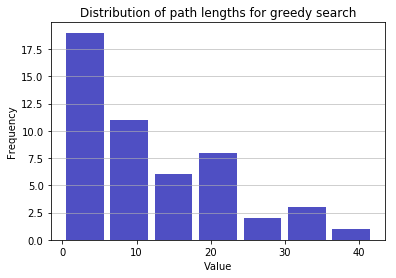

In [34]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=path_lengths, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of path lengths for greedy search')
plt.show()

### Let's try BFS...

In [60]:
start_page = pywikibot.Page(site, 'Vacuum')
for page in start_page.backlinks():
    #print(page.title())

Christopher Wren
Caesium fluoride
User:Mervyn/Latin phrases
Gun laying
Allotropes of phosphorus
Tetrakis(pyridine)silver(II) peroxydisulfate
Tert-Butyl peroxybenzoate
User:Paine Ellsworth/on Cosmology
Crookes radiometer
Metre
Talk:Metre
Watt steam engine
Siphon
Vacuum sewer
Aristotelian physics
Hard suction hose
User talk:Machine Elf 1735
User:Brews ohare/Definitions of the metre
Bendix-Stromberg pressure carburetor
User:Emijrp/Citizendium/index/3
User talk:Sbyrnes321/Archives/2012
User talk:Martin Hogbin/Archive 5
Talk:Vacuum/Archive 3
Portal:Industrial Revolution
Portal:Toilets
Blaise Pascal
Evangelista Torricelli
User:The Anome/Moby nouns/T
Electric current
Electromagnetism
Electromagnetic field
Heinrich Hertz
Inertial frame of reference
Kaluza–Klein theory
History of radio
Spontaneous emission
Transformer
Vacuum
Wavelength
Wave
Communications system
Free-space path loss
Multipath propagation
Path loss
Transmission medium
Wave impedance
Talk:Polarization (waves)
Quantum key distribu

Aether (classical element)
Surface forces apparatus
Pyrolytic carbon
Gluon condensate
QCD vacuum
Vacuum aspiration
Activated alumina
Nothing (disambiguation)
User:Ytrottier
Damper (flow)
Sipper water bottle
Talk:Godwin's law/Archive 1
Connections (TV series)
Space Cases
Perfect Hair Forever
The World (Descartes)
Crankcase
Transformer oil
History of fluid mechanics
Electron optics
Transmission electron cryomicroscopy
Silvering
Camelot 30K
Talk:Aether theories
Thermonuclear weapon
History of thermodynamics
Infrared multiphoton dissociation
Decarburization
Vacuum casting (elastomers)
Blast gate
Museum Boerhaave
Barometric light
Wikipedia:Picture of the day/August 8, 2005
User talk:165.248.247.132
Residual gas analyzer
Brake bleeding
Standard cubic feet per minute
Mother Goose and Grimm
Retarded time
Isotopes of lithium
Standard gravity
Variable capacitor
Thermal power station
Vacuum Technology
User:Mpatel/sandbox/Light cone
Vacuum permittivity
User:Wack'd/Alien experiment (Lilo & Stitch)


User:Ewfwiki
Toku Nishio
User talk:220.239.232.72
User talk:71.213.7.118
Particulate pollution
Chameleon coating
Portal:Catholicism/Selected biography/13
Writing in space
User talk:71.158.199.65
Serge Crasnianski
User:Andeggs/SandboxTwo
Wikipedia:Redirects for discussion/Log/2008 May 6
Talk:Capacitor/Archive 3
User:George D. Watson
User talk:78.149.121.211
User talk:65.96.41.170
Groomer Has It
User talk:77.96.183.82
Wikipedia:Reference desk/Archives/Science/2008 May 15
Jürgen Ehlers
Portal:Biography/Selected article/June 16
Light front quantization
Measuring principle
Prague pneumatic post
Ehlers group
Wikipedia:Reference desk/Archives/Science/2008 June 8
Wikipedia talk:Policies and guidelines/Archive 8
User talk:124.186.101.106
Wikipedia:WikiProject Spam/LinkReports/gresham.ac.uk
Plenum chamber
User talk:Walkerma/Archive18
Geroch group
Molecular mixology
Advanced Life Support in Obstetrics
The Believers: Stories from Jewish Havana
Particle accelerator
Talk:Anthropic units
Weightlessne

User:Elvara11/Books/Physics
User:Patryk.mamla/Books/fizyka
Talk:Vacuum/Archive 3
User talk:RareMonk
COMPASS tokamak
User:Manutdhk
User:W9871/Books/rkr
User:Horreb/Books/universe
Diabetic foot ulcer
User:Ag0700/Books/Optics 1
LSAT (oxide)
Existence of the vacuum
User:Tomtj24/Books/ElectroMagnatism1
User:Tomtj24/Books/Electro - Magnatism
User talk:Wbm1058/Disambiguation link notifications
Neyco
User talk:71.183.16.118
Silver sulfite
User talk:Jenny204012
User talk:Jimbo Wales/Archive 170
User talk:72.77.0.95
User talk:91.187.92.61
User:Markonevet/Books/Vortex Plama Fuel Reforming
User:Markonevet/Books/Vortex Plasma Fuel Reforming Basics
Book:Vortex Plasma Fuel Reforming Basics
Book talk:Vortex Plasma Fuel Reforming Basics
Vacuum (space)
User:Mariusot/Books/my book
User:Robertinventor/Colonization of Mars - old concerns section
User talk:50.205.51.172
User:Johnmorrissci
User:John Morris Scientific
User:Physistsheep/Books/Gravity and Light
Negative energy
Tilting pan filter
User:Killernewt

User:Meegs/r from misspelling
User:Expertseeker90
Talk:Vacuum/Archive 3
Instanton
F-theory
Wikipedia:Articles for deletion/Vacuums
Wikipedia:Articles for deletion/Log/2007 June 12
Joseph Patrick Slattery
User:Carlossuarez46/Smithlist/V
Bicycle tire
Talk:Speed of light/Archive 6
User:Emijrp/Citizendium/index/4
Wikipedia:Articles for deletion/Vacuums
Wikipedia:Articles for deletion/Log/2007 June 12
Rulon (plastic)
Benjamin Bramer
A Beautiful Planet
Wikipedia:Reference desk/Archives/Science/2018 September 4
User:Wmahan/Links to redirects from misspellings
Wikipedia:Reference desk/Archives/Science/2008 February 19
Wikipedia:Articles for deletion/Log/2008 May 7
Wikipedia:Articles for deletion/Onion Juice Therapy
User:TachyonJack/Dealcoholized wine
Talk:Metre
Outer space
Wikipedia:Reference desk/Archives/Science/2010 November 17
User:Emijrp/Citizendium/index/3
User:Dagelf/sandbox


In [ ]:
# finds shortest path between 2 pages using BFS
def bfs_wiki(start, goal, maxBranch=30, verbose=False):
    
    # get start page
    start_page = pywikibot.Page(site, start)
    
    # list of explored pages 
    explored = []
    
    # paths to track
    queue = [[start_page]]
 
    # return path if start is goal
    if start.lower() == goal.lower():
        return [start]
 
    # keeps looping until all possible paths have been checked
    i = 0
    while queue:
        if len(queue) > 50000:
            print("ran for too long")
            return []
        if verbose:
            print("queue is {} long".format(len(queue)))
            print("depth is {}".format(len(queue[-1])))
            
        # pop the first path from the queue
        path = queue.pop(0)
        
        # get the last node from the path
        page = path[-1]
        
        # if we haven't visited a page yet
        if page not in explored:
            
            # get all outgoing links and add to the queue
            for p in page.linkedPages():
                new_path = list(path)
                new_path.append(p)
                queue.append(new_path)
                
                # return path if link is goal
                if p.title().lower() == goal.lower():
                    return new_path
 
            # mark page as explored
            explored.append(page)
 
    # failure 
    return "Sorry, we couldn't find a path... :("

In [96]:
# finds shortest path between 2 nodes of a graph using BFS
def bi_bfs_wiki(start, goal, verbose=True):
    
    start_page = pywikibot.Page(site, start)
    goal_page = pywikibot.Page(site, goal)
    
    # keep dictionary of visited pages and the path to reach them
    explored_f = {start_page: [start_page]}
    explored_b = {goal_page: [goal_page]}
    
    queue_f = [[start_page]]
    queue_b = [[goal_page]]
 
    # return path if start is goal
    if start.lower() == goal.lower():
        return [start.title()]
 
    # keeps looping until all possible paths have been checked
    while not len(queue_f)==0 and not len(queue_b)==0:
        print("num forward: {}, num back: {}".format(len(queue_f[-1]),len(queue_b[-1])))
        
        # get next unvisited page looking forward
        path_f = queue_f.pop(0)
        page_f = path_f[-1]
        if page_f in list(explored_b.keys()):
            print("found path going forward")
            return path_f + list(reversed(explored_b[page_f]))

        # get next unvisited page looking back
        path_b = queue_b.pop(0)
        page_b = path_b[-1]
        if page_b in list(explored_f.keys()):
            print("found path going backwards")
            return explored_f[page_b] + list(reversed(path_b))
        
        # pick direction with fewer outgoing/ingoing links
        #if len(page_f.linkedPages())< len(page_b.backlinks()): # can't do this
            
        # bfs as usual
        for p in page_f.linkedPages():
            new_path_f = list(path_f)
            new_path_f.append(p)
            queue_f.append(new_path_f)

            # return path if next page is goal
            if p.title().lower() == goal.lower():
                print("found goal")
                return new_path_f

            # return path is next page is in backwards direction
            if p in list(explored_b.keys()):
                print("found a connection going forwards")
                return new_path_f +  list(reversed(explored_b[p]))
            
        # mark node as explored
        explored_f[p] = new_path_f
        
        # next go in the backwards direction
        # bfs in reverse
        
        for p in page_b.backlinks():
            new_path_b = list(path_b)
            new_path_b.append(p)
            queue_b.append(new_path_b)

            # return path if next page is goal
            if p.title().lower() == start.lower():
                print("found start")
                return list(reversed(new_path_b))

            # return path is next page is in backwards direction
            if p in list(explored_f.keys()):
                print("found a connection going backwards")
                return explored_f[p] + list(reversed(new_path_b))
        
        # mark node as explored
        explored_b[p] = new_path_b
 
    # in case there's no path between the 2 nodes
    return "Sorry, but a connecting path doesn't exist :("

In [98]:
bi_bfs_wiki("Trigonometry","Adolf Hitler")
#bi_bfs_wiki("Colt 45","American Dream")

num forward: 1, num back: 1
num forward: 2, num back: 2
num forward: 3, num back: 2
num forward: 3, num back: 2
num forward: 3, num back: 2
found a connection going forwards


[Page('Trigonometry'),
 Page('Algebra'),
 Page('Portal:Mathematics'),
 Page('Wikipedia:Database reports/Tagged redirect misspellings'),
 Page('Adolf Hitler')]

In [95]:
l = [1,2,3]
l = list(reversed(l))
print(l)

[3, 2, 1]


In [ ]:
[Page('Colt 45'),
 Page('Help:Disambiguation'),
 Page("Help:Wikipedia: The Missing Manual/Appendixes/Reader's guide to Wikipedia"),
 Page('American Dream'),
 Page('The Adventures of Augie March'),
 User('User:Jogers/Capitalization')]

In [54]:
paths[9]

['Life expectancy',
 'Template talk:Longevity',
 'Matlab',
 'MATLAB',
 'Graphical user interface']

In [99]:
# get path length for 50 samples
path_lengths_bfs = []
paths_bfs = []
for start, goal in examples:
    print("start: {}, goal: {}".format(start,goal))
    
        path = bfs_wiki(start, goal)
    paths.append(path)
    path_lengths.append(len(path))
    


queue is 1 long
depth is 1
queue is 263 long
depth is 2
queue is 264 long
depth is 3
queue is 273 long
depth is 3
queue is 273 long
depth is 3
queue is 286 long
depth is 3
queue is 323 long
depth is 3
queue is 479 long
depth is 3
queue is 479 long
depth is 3
queue is 895 long
depth is 3
queue is 1080 long
depth is 3
queue is 1214 long
depth is 3
queue is 1322 long
depth is 3
queue is 1917 long
depth is 3
queue is 5022 long
depth is 3
queue is 5071 long
depth is 3
queue is 5259 long
depth is 3
queue is 5597 long
depth is 3
queue is 5623 long
depth is 3
queue is 6129 long
depth is 3
queue is 6277 long
depth is 3
queue is 6306 long
depth is 3
queue is 6413 long
depth is 3
queue is 6632 long
depth is 3
queue is 6756 long
depth is 3
queue is 6893 long
depth is 3
queue is 7675 long
depth is 3
queue is 7707 long
depth is 3
queue is 8266 long
depth is 3
queue is 9131 long
depth is 3
queue is 9446 long
depth is 3
queue is 9446 long
depth is 3
queue is 9770 long
depth is 3
queue is 10034 long
de

[Page('Life expectancy'), Page('EViews'), Page('Graphical user interface')]

In [ ]:
bfs_wiki(examples[9][0], examples[9][1])

[Page('Life expectancy'),
 Page('AIDS'),
 Page('Wikipedia:Protection policy'),
 Page('Tooltip'),
 Page('Graphical user interface')]

In [ ]:
"""
Runs a bi-directional breadth-first search between two Wikipedia articles and returns a list of
the shortest paths between them.
"""


def get_paths(page_ids, visited_dict):
    """Returns a list of paths which go from the provided pages to either the source or target pages.
  Args:
    page_ids: The list of page IDs whose paths to get.
  Returns:
    list(list(int)): A list of lists of page IDs corresponding to paths from the provided page IDs
      to the source or target pages.
  """
  paths = []

  for page_id in page_ids:
    if page_id is None:
      # If the current page ID is None, it is either the source or target page, so return an empty
      # path.
      return [[]]
    else:
      # Otherwise, recursively get the paths for the current page's children and append them to
      # paths.
      current_paths = get_paths(visited_dict[page_id], visited_dict)
      for current_path in current_paths:
        new_path = list(current_path)
        new_path.append(page_id)
        paths.append(new_path)

  return paths


def breadth_first_search(source_page_id, target_page_id, database):
  """Returns a list of shortest paths from the source to target pages by running a bi-directional
  breadth-first search on the graph of Wikipedia pages.
  Args:
    source_page_id: The page at which to start the search.
    target_page_id: The page at which to end the search.
    database: An Database instance which contains methods to query the Wikipedia database.
  Returns:
    list(list(int)): A list of lists of page IDs corresponding to paths from the source page to the
      target page.
  """
  # If the source and target page IDs are identical, return the trivial path.
  if source_page_id == target_page_id:
    return [[source_page_id]]

  paths = []

  # The unvisited dictionaries are a mapping from page ID to a list of that page's parents' IDs.
  # None signifies that the source and target pages have no parent.
  unvisited_forward = {source_page_id: [None]}
  unvisited_backward = {target_page_id: [None]}

  # The visited dictionaries are a mapping from page ID to a list of that page's parents' IDs.
  visited_forward = {}
  visited_backward = {}

  # Set the initial forward and backward depths to 0.
  forward_depth = 0
  backward_depth = 0

  # Continue the breadth first search until a path has been found or either of the unvisited lists
  # are empty.
  while (len(paths) == 0) and ((len(unvisited_forward) != 0) and (len(unvisited_backward) != 0)):
    # Run the next iteration of the breadth first search in whichever direction has the smaller number
    # of links at the next level.
    forward_links_count = database.fetch_outgoing_links_count(unvisited_forward.keys())
    backward_links_count = database.fetch_incoming_links_count(unvisited_backward.keys())

    if forward_links_count < backward_links_count:
      #---  FORWARD BREADTH FIRST SEARCH  ---#
      forward_depth += 1

      # Fetch the pages which can be reached from the currently unvisited forward pages.
      # The replace() bit is some hackery to handle Python printing a trailing ',' when there is
      # only one key.
      outgoing_links = database.fetch_outgoing_links(unvisited_forward.keys())

      # Mark all of the unvisited forward pages as visited.
      for page_id in unvisited_forward:
        visited_forward[page_id] = unvisited_forward[page_id]

      # Clear the unvisited forward dictionary.
      unvisited_forward.clear()

      for source_page_id, target_page_ids in outgoing_links:
        for target_page_id in target_page_ids.split('|'):
          if target_page_id:
            target_page_id = int(target_page_id)
            # If the target page is in neither visited forward nor unvisited forward, add it to
            # unvisited forward.
            if (target_page_id not in visited_forward) and (target_page_id not in unvisited_forward):
              unvisited_forward[target_page_id] = [source_page_id]

            # If the target page is in unvisited forward, add the source page as another one of its
            # parents.
            elif target_page_id in unvisited_forward:
              unvisited_forward[target_page_id].append(source_page_id)

    else:
      #---  BACKWARD BREADTH FIRST SEARCH  ---#
      backward_depth += 1

      # Fetch the pages which can reach the currently unvisited backward pages.
      incoming_links = database.fetch_incoming_links(unvisited_backward.keys())

      # Mark all of the unvisited backward pages as visited.
      for page_id in unvisited_backward:
        visited_backward[page_id] = unvisited_backward[page_id]

      # Clear the unvisited backward dictionary.
      unvisited_backward.clear()

      for target_page_id, source_page_ids in incoming_links:
        for source_page_id in source_page_ids.split('|'):
          if source_page_id:
            source_page_id = int(source_page_id)
            # If the source page is in neither visited backward nor unvisited backward, add it to
            # unvisited backward.
            if (source_page_id not in visited_backward) and (source_page_id not in unvisited_backward):
              unvisited_backward[source_page_id] = [target_page_id]

            # If the source page is in unvisited backward, add the target page as another one of its
            # parents.
            elif source_page_id in unvisited_backward:
              unvisited_backward[source_page_id].append(target_page_id)

    #---  CHECK FOR PATH COMPLETION  ---#
    # The search is complete if any of the pages are in both unvisited backward and unvisited, so
    # find the resulting paths.
    for page_id in unvisited_forward:
      if page_id in unvisited_backward:
        paths_from_source = get_paths(unvisited_forward[page_id], visited_forward)
        paths_from_target = get_paths(unvisited_backward[page_id], visited_backward)

        for path_from_source in paths_from_source:
          for path_from_target in paths_from_target:
            current_path = list(path_from_source) + [page_id] + list(reversed(path_from_target))

            # TODO: This line shouldn't be required, but there are some unexpected duplicates.
            if current_path not in paths:
              paths.append(current_path)

  return paths